In [1]:
import torch

In [2]:
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

CUDA is available on this system.


In [3]:
# load convext_tiny model
model = convnext_tiny(pretrained=True)

/home/ippen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ippen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model_without_classifier = nn.Sequential(*list(model.children())[:-1])

In [5]:
model_without_classifier.to('cuda').eval()

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, o

In [6]:
# Get the output shape of the model
model_without_classifier.forward(torch.randn(1, 3, 224, 224).to('cuda')).shape

torch.Size([1, 768, 1, 1])

In [7]:
import torch.nn.functional as F

def getCosineSimilarityScore(embedding1, embedding2):
    """
    Calculate the cosine similarity between two image embeddings.
    
    Args:
        embedding1 (torch.Tensor): Image embedding of shape (1, C, 1, 1).
        embedding2 (torch.Tensor): Image embedding of shape (1, C, 1, 1).
        
    Returns:
        float: Cosine similarity score between the two embeddings.
    """
    # Normalize the embeddings
    normalized_embedding1 = F.normalize(embedding1, dim=1)
    normalized_embedding2 = F.normalize(embedding2, dim=1)
    
    # Calculate dot product
    dot_product = torch.sum(normalized_embedding1 * normalized_embedding2)
    
    # Calculate norms
    norm1 = torch.norm(normalized_embedding1)
    norm2 = torch.norm(normalized_embedding2)
    
    # Calculate cosine similarity
    cosine_similarity = dot_product / (norm1 * norm2)
    
    return cosine_similarity.item()

# # Example usage
# embedding1 = torch.randn(1, 768, 1, 1).to('cuda')
# embedding2 = torch.randn(1, 768, 1, 1).to('cuda')
# print("Cosine Similarity embedding 1 to itself:", getCosineSimilarityScore(embedding1, embedding1))
# print("Cosine Similarity embedding 1 to 2:", getCosineSimilarityScore(embedding1, embedding2))


In [8]:
def get_embedding(image_path, model):
    img = PILImage.create(image_path)
    trans = transforms.ToTensor()
    img_tensor = trans(img).unsqueeze(0).to('cuda')
    with torch.no_grad():
        embedding = model.forward(img_tensor)
    return embedding

In [9]:
folder_path = "test_images"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

In [13]:
from torchvision import transforms

num_images = len(image_files)
similarity_matrix = np.zeros((num_images, num_images))
tfImgtoTensor = transforms.ToTensor()

# Calculate similarity scores and populate the matrix
for i in range(num_images):
    for j in range(i, num_images):
        img1 = PILImage.create(image_files[i])
        img2 = PILImage.create(image_files[j])
        
        embedding1 = model_without_classifier.forward(tfImgtoTensor(img1).unsqueeze(0).to('cuda'))
        embedding2 = model_without_classifier.forward(tfImgtoTensor(img2).unsqueeze(0).to('cuda'))
        
        similarity_score = getCosineSimilarityScore(embedding1, embedding2)
        
        similarity_matrix[i, j] = similarity_score
        similarity_matrix[j, i] = similarity_score  # Matrix is symmetric

print(similarity_matrix)

[[1.00000012 0.91736871 0.68296915 0.66217482 0.5799005 ]
 [0.91736871 1.         0.70374322 0.67228138 0.60973084]
 [0.68296915 0.70374322 1.         0.89914167 0.76494169]
 [0.66217482 0.67228138 0.89914167 1.         0.74605507]
 [0.5799005  0.60973084 0.76494169 0.74605507 1.        ]]


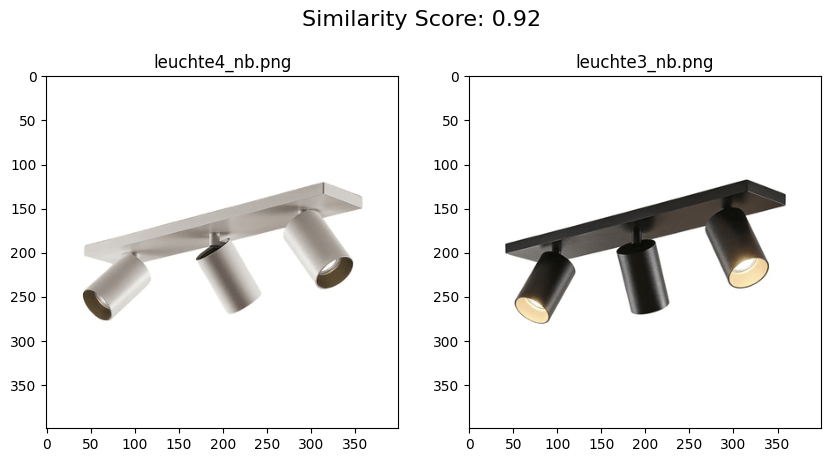

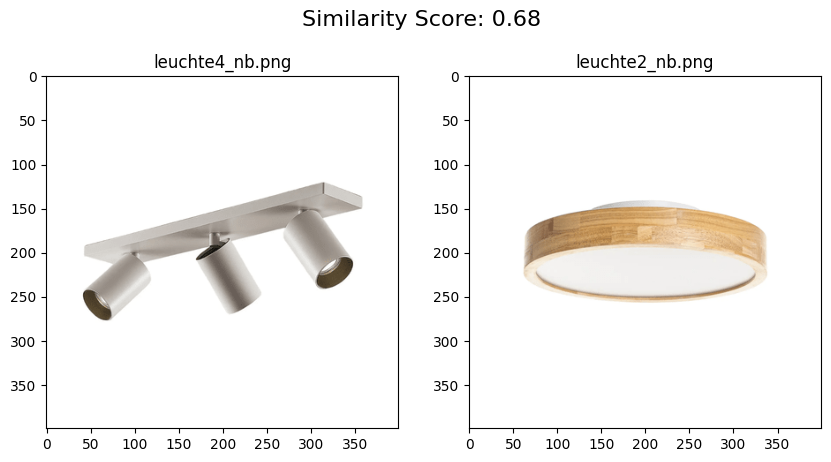

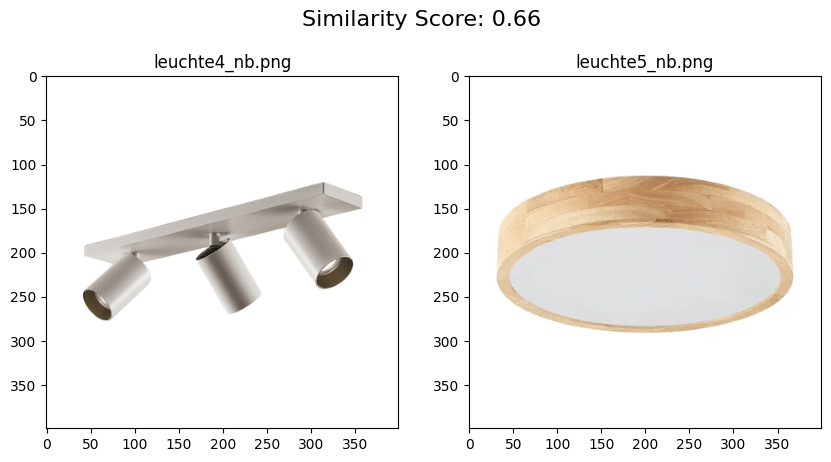

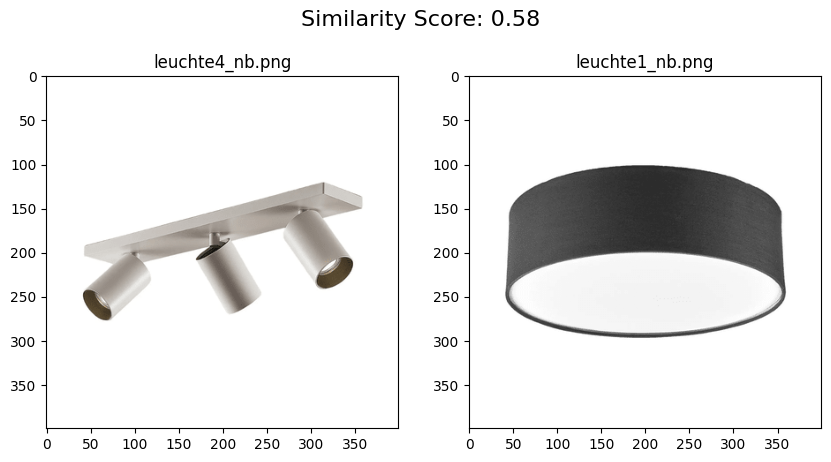

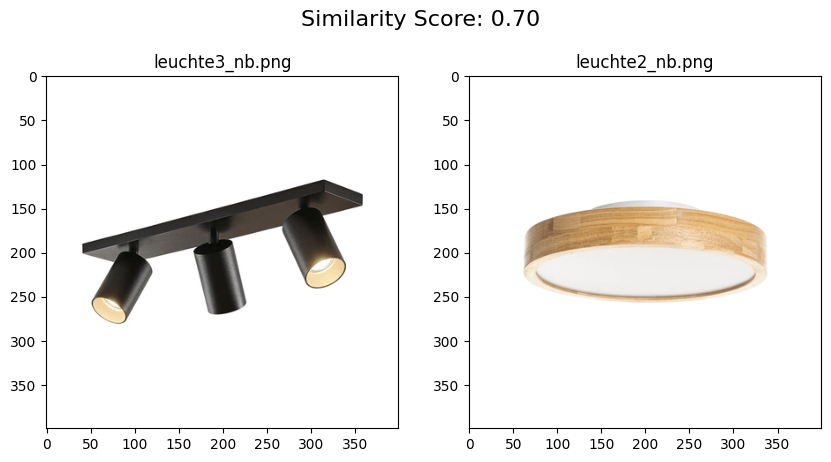

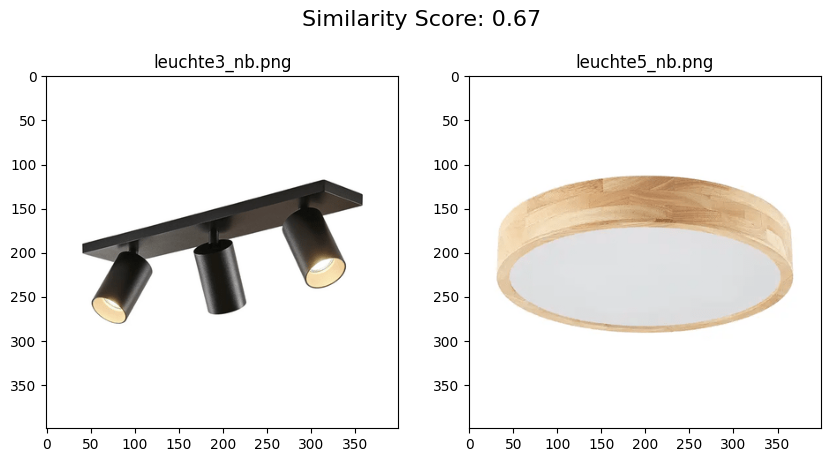

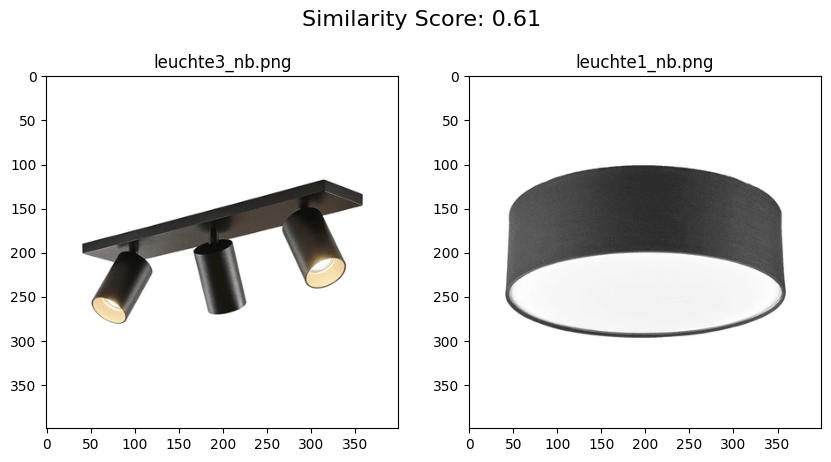

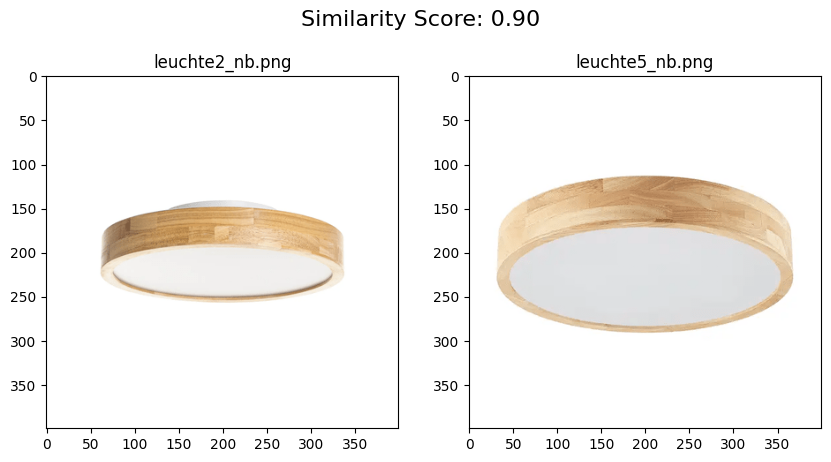

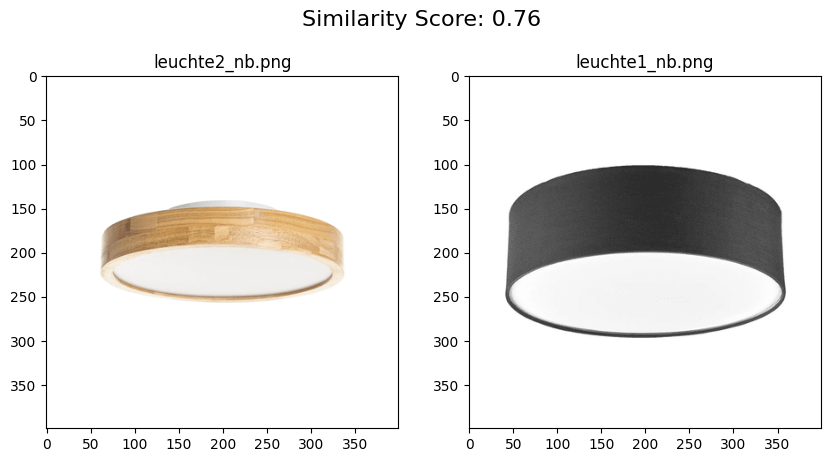

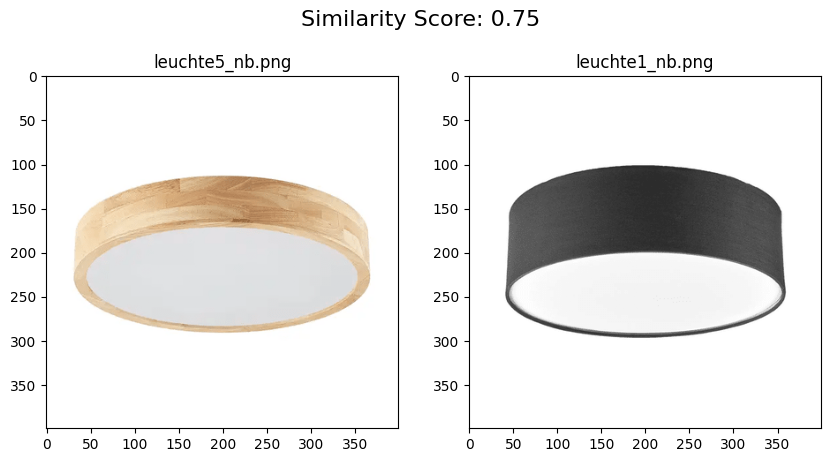

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to plot image pairs
def plot_image_pairs(image_files, similarity_matrix):
    num_images = len(image_files)
    
    # Iterate through each image pair and plot them along with their similarity score
    for i in range(num_images):
        for j in range(i + 1, num_images):
            img1_path = image_files[i]
            img2_path = image_files[j]
            
            img1 = mpimg.imread(img1_path)
            img2 = mpimg.imread(img2_path)
            
            similarity_score = similarity_matrix[i, j]
            
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img1)
            plt.title(os.path.basename(img1_path))
            
            plt.subplot(1, 2, 2)
            plt.imshow(img2)
            plt.title(os.path.basename(img2_path))
            
            plt.suptitle(f'Similarity Score: {similarity_score:.2f}', fontsize=16)
            
            plt.show()

# Call the function to plot image pairs
plot_image_pairs(image_files, similarity_matrix)
